# 1. segmentation-stats

To generate stats, we will read the summary files for different datasets in `summary folder`. The summary folder contains folders named after the dataset name. Each dataset folder contains summary files extacted by respective scripts. The summary files are in json format. We will read the json files and generate stats.

We will generate per dataset stats and general stats combining all the datasets.

Among the stats, we will generate the following:
The results will be saved in summaries in respective dataset folders.

In [1]:
# expose parent directory to import modules
import os
import sys

ROOT_DIR = os.getcwd()
while os.path.basename(ROOT_DIR) != 'vision-datasets-stats':
    ROOT_DIR = os.path.abspath(os.path.join(ROOT_DIR,'..'))
sys.path.insert(0,ROOT_DIR)
os.chdir(ROOT_DIR)

TASK = 'segmentation'

In [2]:


# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from pathlib import Path
import json
import warnings
from collections import defaultdict
sns.set()

from utils import stats_tools
warnings.filterwarnings('ignore')

In [3]:
#

summaries_path = Path('./summaries')
summaries_path= summaries_path / TASK
summaries_path.mkdir(parents=True, exist_ok=True)

In [4]:
# get dataset to file paths
dataset_to_file_paths = stats_tools.get_dataset_to_file_paths(str(summaries_path))


In [5]:

global_summary_plain_value_cols_df = pd.DataFrame()
global_summary_images_stats = pd.DataFrame()
global_summary_masks_stats = pd.DataFrame()
global_areas_ranges_stats = defaultdict(list)
global_areas_ratios_general_stats = defaultdict(list)

for dataset_name, file_path in dataset_to_file_paths.items():
    
    print("*"*20 + f"{dataset_name}" + "*"*20)
    # load data
    summary = stats_tools.load_summary(file_path=file_path)

    if ("_masks_stats" not in summary.keys()) \
          or (summary["_masks_stats"] is None) \
            or not (summary["_masks_stats"]["_is_masks"]) \
                or (int(summary["_masks_stats"]["masks_count"])==0):
        continue

    dataset_to_summary = {dataset_name: summary}

    # plain-common-stats-stats-plots-save
    all_columns = list(summary.keys())
    plain_value_cols = {}
    plain_value_cols["dataset_name"] = dataset_name
    plain_value_cols.update({ k:v for (k,v) in summary.items() if not isinstance(summary[k], (list, dict))})
    plain_value_cols_df=pd.DataFrame(plain_value_cols, index=[0])
    global_summary_plain_value_cols_df=stats_tools.merge_df(df1=global_summary_plain_value_cols_df, 
                                                            df2=plain_value_cols_df)
    
    #summarize _categories_stats for each dataset
    stats_tools.summarize_category_stats(dataset_name=dataset_name,
                                         _categories_stats = summary['_categories_stats'],
                                         save_path=summaries_path)
    
    # summarize_images_stats
    _images_stats_df = pd.DataFrame({"dataset_name":dataset_name, **summary['_images_stats']}, index=[0])
    global_summary_images_stats=stats_tools.merge_df(df1=global_summary_images_stats, 
                                                            df2=_images_stats_df)
    
    # summarize _masks_stats
    _masks_stats_df = pd.DataFrame({"dataset_name":dataset_name, **summary['_masks_stats']}, index=[0])
    global_summary_masks_stats=stats_tools.merge_df(df1=global_summary_masks_stats, 
                                                            df2=_masks_stats_df)

    ##skydata/coco sizes boxes boxes stats
    # 
    boxes_stats=summary['_boxes_stats']
    areas_ranges_stats=boxes_stats['areas_ranges_stats']

    global_areas_ranges_stats["dataset_name"].append(dataset_name)
    [global_areas_ranges_stats[k].append(v) for k,v in areas_ranges_stats.items()]

    ## per datasets ratios stats
    _ratios={"dataset_name":dataset_name, 
             "ratios_hist":summary['_boxes_stats']['ratios_hist']}
    stats_tools.plot_save_per_dataset_ratios_hist(_ratios=_ratios,
                                                    save_path=summaries_path/dataset_name/'plots',
                                                    file_name=f'{dataset_name}_ratios_hist')
    
    ## global ratios and areas stats
    #_is_bboxes, areas_stats, ratios_stats,areas_ranges
    _area_ratio_stats=stats_tools.get_formated_area_stats_per_dataset(dataset_name=dataset_name, 
                                                    boxes_stats=boxes_stats)
    [global_areas_ratios_general_stats[k].append(v) for k,v in _area_ratio_stats.items()]
    

********************DOTA********************
[INFO] Loading dotav2_converted_to_coco_stats.json
[INFO] Loaded dotav2_converted_to_coco_stats.json
[INFO] Category stats ....
[INFO] saving plot ....
[INFO] saving csv ....
[INFO] Saving plots
[INFO] Saved DOTA_per_category_stats.csv
[INFO] Saved.
[INFO] per dataset ratios stats ....
[INFO] Saving...
[INFO] Saved.
********************skydata********************
[INFO] Loading train_DET_stats.json
[INFO] Loaded train_DET_stats.json
[INFO] Category stats ....
[INFO] saving plot ....
[INFO] saving csv ....
[INFO] Saving plots
[INFO] Saved skydata_per_category_stats.csv
[INFO] Saved.
[INFO] per dataset ratios stats ....
[INFO] Saving...
[INFO] Saved.
********************vhr_10********************
[INFO] Loading vhr_annotations_stats.json
[INFO] Loaded vhr_annotations_stats.json
[INFO] Category stats ....
[INFO] saving plot ....
[INFO] saving csv ....
[INFO] Saving plots
[INFO] Saved vhr_10_per_category_stats.csv
[INFO] Saved.
[INFO] per datase

In [6]:
# plot generals and save stats
if ("_masks_stats" not in summary.keys()) \
        or (summary["_masks_stats"] is None) \
        or not (summary["_masks_stats"]["_is_masks"]) \
            or (int(summary["_masks_stats"]["masks_count"])==0):
    ## global_summary_plain_value_cols_df save to csv
    stats_tools.save_df_to_csv(df=global_summary_plain_value_cols_df,
                                save_path=summaries_path/'all_datasets',
                                file_name=f'{TASK}_plain_value_global.csv')


    ## global_summary_images_stats save to csv
    stats_tools.summarize_global_images_plot_and_save(global_summary_images_stats=global_summary_images_stats,
                                                    save_path=summaries_path/'all_datasets',
                                                    file_name=f'{TASK}_images_stats_global')

    ## global_summary_masks_stats save to csv
    stats_tools.summarize_global_summary_masks_stats_plot_and_save(global_summary_masks_stats=global_summary_masks_stats,
                                                    save_path=summaries_path/'all_datasets',
                                                    file_name=f'{TASK}_masks_stats_global')

    # ## global_areas_ranges_stats save to csv
    stats_tools.summarize_global_areas_ranges_stats_plot_and_save(global_areas_ranges_stats_df=global_areas_ranges_stats,
                                                    save_path=summaries_path/'all_datasets',
                                                    file_name=f'{TASK}_areas_ranges_stats_global')

    # ## global_areas_ratios_general_stats save to csv
    stats_tools.summarize_global_areas_ratios_general_stats_plot_and_save(stats=global_areas_ratios_general_stats,
                                                                        save_path=summaries_path/'all_datasets',
                                                                        file_name=f'{TASK}_areas_ratios_general_stats')

In [9]:
global_summary_plain_value_cols_df.columns

Index(['dataset_name', 'annotations_count', 'created_by', 'description',
       'images_count', 'task', 'dataset_size', 'categories_count'],
      dtype='object')

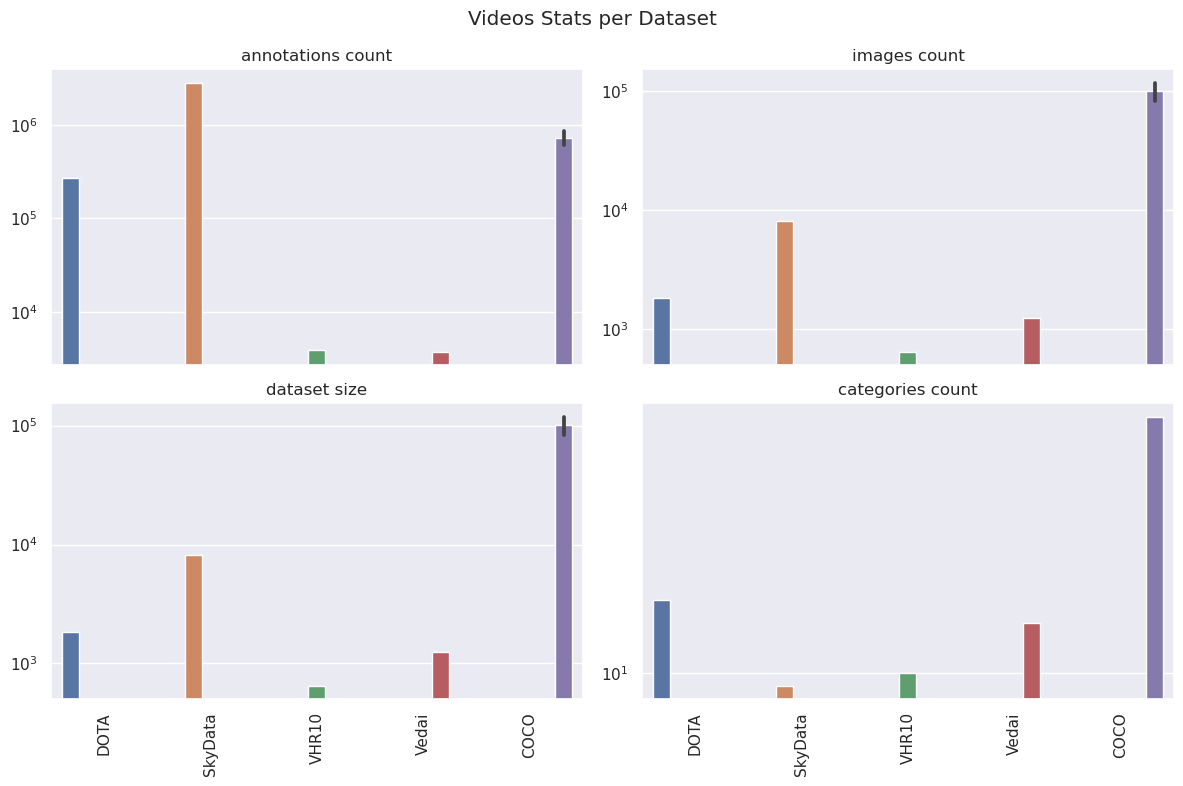

In [21]:
"""
sequence lengths
"""



import seaborn as sns
import matplotlib.pyplot as plt

# df.keys()
# some plots
df = global_summary_plain_value_cols_df

# plot distributions

# Create a grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Videos Stats per Dataset')
plt.yscale('log')
interested_in =['annotations_count', 
                'images_count',
                'dataset_size', 
                'categories_count'
                ]

rows = 2
cols = 2
for i in range(rows):
    for j in range(cols):    
        interested_idx = i*rows + j
        interested = interested_in[interested_idx]
        
        if interested == 'video_count':
            with sns.axes_style("ticks"):
                sns.barplot(data=df, x='dataset_name', y=f'{interested}', ax=axes[i, j])
                axes[i, j].set_title(f'{str(interested.replace("_"," "))}')
                axes[i, j].set_xlabel('')
                axes[i, j].set_ylabel(f'{interested}')
                axes[i, j].tick_params(axis='x', rotation=90 , labelbottom=False)
                axes[i, j].tick_params(axis='y', labelleft=False)
        
        else:            
            with sns.axes_style("ticks"):
                axes[i, j].set(yscale="log")
                sns.barplot(data=df, x='dataset_name', 
                                y=f'{interested}', 
                                ax=axes[i, j], 
                                hue="dataset_name"
                                )
                axes[i, j].set_title(f'{str(interested.replace("_"," "))}')
                axes[i, j].set_xlabel('')
                axes[i, j].set_ylabel('')
                axes[i, j].tick_params(axis='x', rotation=90, labelbottom=False)
                axes[i, j].tick_params(axis='y', labelleft=True)
                axes[i, j].legend(ncol=1, fontsize=5, loc="upper center", frameon=False).remove()


# show ticks for the last row
for j in range(cols):
    axes[rows-1, j].tick_params(axis='x', rotation=90, labelbottom=True)

# Adjust spacing
plt.tight_layout()
# Show the plots
# plt.show()


file_name = f'{TASK}_general_stats'
save_path = Path("summaries/showcase")
save_path.mkdir(parents=True, exist_ok=True)
plt.savefig(str(save_path/f'{file_name}.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()
